## TuMag's reduction example

In this file we provide an example of the reduction for an aobserving mode of TuMag starting from a fits file.



2 paths should be identified before starting the demodulation, the local directory where the TuMag's pipeline is located and the fits file to reduce. 

In [1]:
# SUBSTITUTE for local paths
pipeline_path = "/home/pablo/Desktop/TuMag/TuMags_Reduction_Pipeline"
fits_file = "/media/HDD/TuMag_data/obs/01_QSUN_TM_00_Fe2.02_8_10072024T133713_LV_0.6_v1.0.fits"

### Imports

We need the following libraries to be imported for the reduction.

From external libraries:
 - fits from astropy.io -> For fits file reading.
 - sys -> For paths handling. (optional, we use it this guide but are not required)
 - matplotlib.pyplot -> For representation (optional, we use it this guide but are not required)  

From the TuMag's pipeline, the following routines must be imported: 
 - align_obs_mode from alignment.py
 - demodulate from demodulation.py
 - fit_muller_matrix from xtalk_jaeggli.py


In [2]:
# IMPORTS

# External libraries
import sys      
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt # Optional, Required for representation

# TuMag pipeline functions
sys.path.append(pipeline_path) 
from alignment import align_obsmode 
from demodulation import demodulate
from xtalk_jaeggli import fit_mueller_matrix

show_plots = True # Variable to generate representations.

/home/pablo/Desktop/TuMag/TuMags_Reduction_Pipeline/virtenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Representation functions - Skip if no representation is wanted 
from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

def plot_4_stokes(data, lims = None, title = None):
    fig, axs = plt.subplots(1, 4, figsize = (21, 5))
    if title is not None:
        fig.suptitle(title)
    for i in range(4):
        if lims is None:
            im = axs[i].imshow(data[i], cmap = "gray")
        else:
            im = axs[i].imshow(data[i], cmap = "gray", clim = lims[i])
        colorbar(im)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        plt.tight_layout()
    plt.show()

### Loading the data
We load the fits data file with the _getdata_ routine and the header with the _getheader_ from the module _astropy.io_. 

TuMag's fits files have the following dimensions -> (Ncams, Nlambda, Nmods, Nx, Ny), for data not yet demodulated (reduction levels lower than 1.0), and (Nlambda, Nstokes, Nx, Ny) for already demodulated data (reduction levels from 1.0 onwards).

For the reduction procedure we need the following information from the header: 
 - Spectral line. 

We can also read some other useful information, such as:
 - Number of modulations.
 - Number of wavelengths. 
 - Observing modes. 

Data shape: (2, 8, 4, 1644, 1644)
Data properties:
Observing mode: 2.02 - Spectral line 525.02
Nº of Modulations : 4
Nº of Wavelengths 8


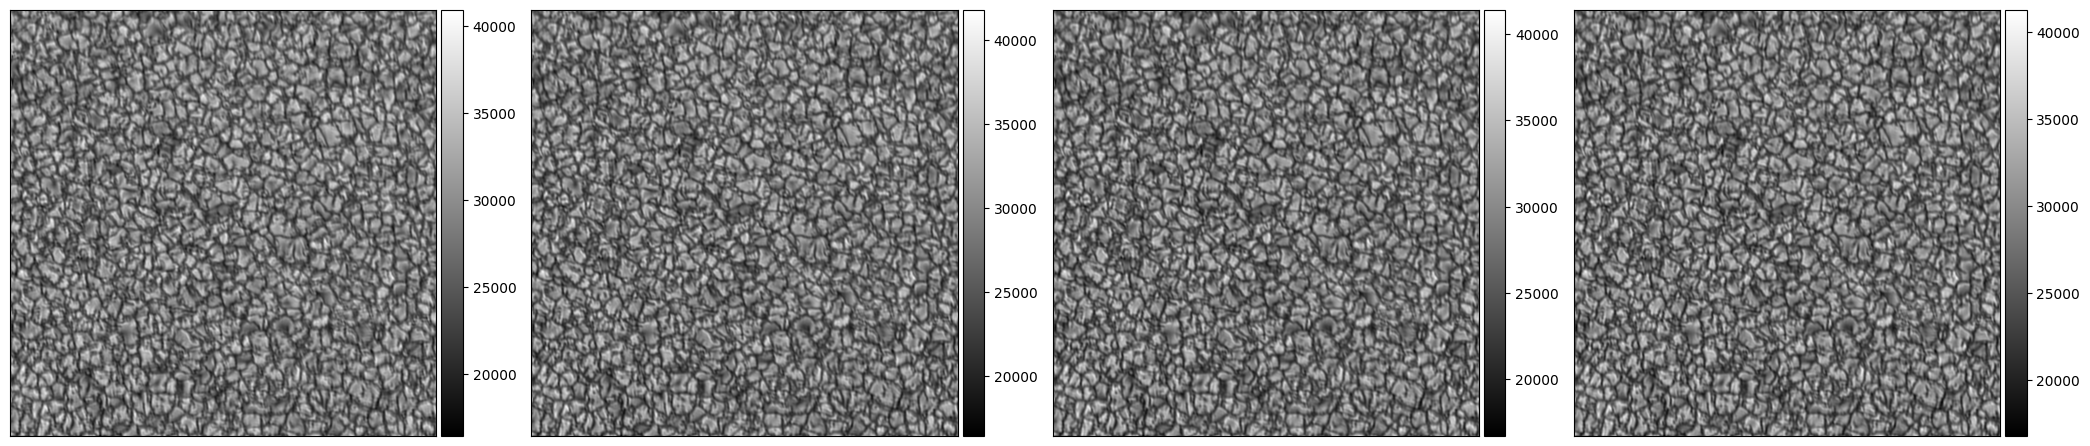

In [4]:
# LOAD the data
obs_data = fits.getdata(fits_file)      # Get the data array
obs_info = fits.getheader(fits_file)    # Get the header

nmods = obs_info["NMODS"]       # Number of modulations
nlambda = obs_info["NLAMBDA"]   # Number of wavelengths
line = obs_info["FW2"]          # Spectral line - REQUIRED
obsmode = obs_info["OBS_MODE"]  # Observation mode 

# Print info of the data block
print(f"Data shape: {obs_data.shape}")
print(f"Data properties:\nObserving mode: {obsmode} - Spectral line {line}\nNº of Modulations : {nmods}\nNº of Wavelengths {nlambda}")

# Show the four modulations of the first wavelength and first camera. 
if show_plots:
    plot_4_stokes(obs_data[0, 0])

### Filter and alignment 

Since the fits file we employed has a reduction level lower than 0.8 we need to align and filter the data before demodulating. 

We are going to use the  __align_obsmode__ routine from the module _alignment.py_. 

Approximated execution time (~ 2 min)

In [5]:
# ALIGN the data. 
aligned = align_obsmode(obs_data, verbose = True) # verbose = True to track the progress. Can be turned off. 

Procesing filtration of wavelength: 1 / 8
Time elapsed: 1.926 s.
Procesing filtration of wavelength: 2 / 8
Time elapsed: 1.919 s.
Procesing filtration of wavelength: 3 / 8
Time elapsed: 1.894 s.
Procesing filtration of wavelength: 4 / 8
Time elapsed: 1.878 s.
Procesing filtration of wavelength: 5 / 8
Time elapsed: 1.873 s.
Procesing filtration of wavelength: 6 / 8
Time elapsed: 1.896 s.
Procesing filtration of wavelength: 7 / 8
Time elapsed: 1.93 s.
Procesing filtration of wavelength: 8 / 8
Time elapsed: 1.923 s.
Filtering process completed.

Computing camera 2 rotation...
Rotation finished.

Aligning wavelengh: 1/8
Shifts for cam 1 - modulation alignment
Re-aligning images ...


/home/pablo/Desktop/TuMag/TuMags_Reduction_Pipeline/alignment.py:63: RuntimeWarning: invalid value encountered in sqrt
  error=np.sqrt(1-np.abs(CCmax)**2/(rg00*rf00))


Shift of image: 0 -> row : 0.0 col : 0.0
Shift of image: 1 -> row : 0.23 col : -0.11
Shift of image: 2 -> row : 0.11 col : 0.03
Shift of image: 3 -> row : -0.03 col : 0.13
Shifts of camera 2 alignment
mod -> 0...
Re-aligning images ...
Shift of image: 0 -> row : 0.0 col : 0.0
Shift of image: 1 -> row : -0.71 col : -3.29
mod -> 1...
Re-aligning images ...
Shift of image: 0 -> row : 0.0 col : 0.0
Shift of image: 1 -> row : -0.64 col : -3.37
mod -> 2...
Re-aligning images ...
Shift of image: 0 -> row : 0.0 col : 0.0
Shift of image: 1 -> row : -0.79 col : -3.37
mod -> 3...
Re-aligning images ...
Shift of image: 0 -> row : 0.0 col : 0.0
Shift of image: 1 -> row : -0.79 col : -3.34
Aligning wavelengh: 2/8
Shifts for cam 1 - modulation alignment
Re-aligning images ...
Shift of image: 0 -> row : 0.0 col : 0.0
Shift of image: 1 -> row : 0.09 col : 0.14
Shift of image: 2 -> row : 0.2 col : 0.05
Shift of image: 3 -> row : 0.05 col : 0.13
Shifts of camera 2 alignment
mod -> 0...
Re-aligning images

### Demodulating
After alignment, we can demodulate the data to compute the Stokes components with the demodulation routine from the module _demodulation.py_.

In addition to the aligned data, this function needs the spectral line to be able to select the demodulation matrix.

In [6]:
stokes = demodulate(aligned, filt = line)

## Correcting the xtalk. 

After demodulation, a first cross-talk correction is required. This correction can be performed with the __fit_mueller_matrix__ routine from the __xtalk_jaeggli.py__ module

In [7]:
xtalk_corr, _ = fit_mueller_matrix(stokes)

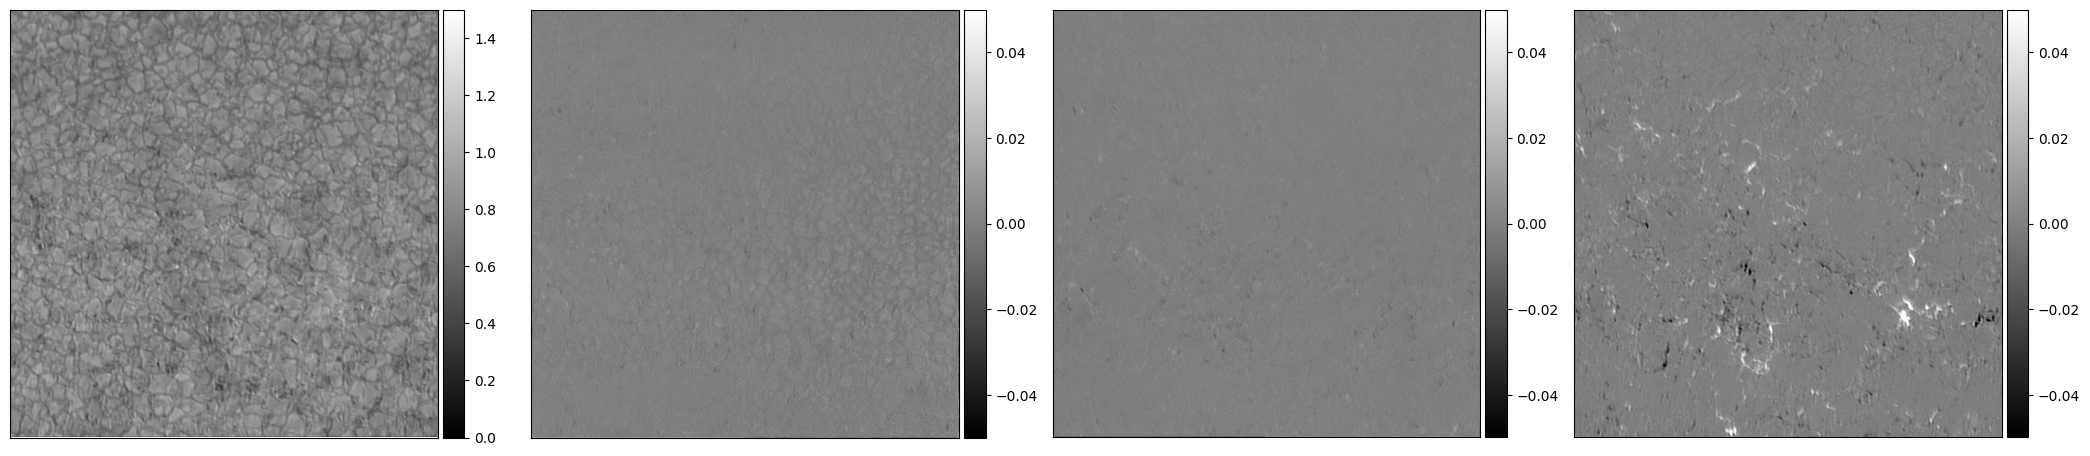

In [8]:
# Plot the final result for the third wavelength. 
median = np.median(xtalk_corr[0, 0])
if show_plots:
    plot_4_stokes(xtalk_corr[3] / median, lims = [[0, 1.5], [-0.05, 0.05], [-0.05, 0.05], [-0.05, 0.05]])